<a href="https://colab.research.google.com/github/Sanford-Lab/satellite_cnns/blob/main/benin_apache_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This notebook is based on the tutorial for [land cover classification.](https://colab.research.google.com/github/GoogleCloudPlatform/python-docs-samples/blob/main/people-and-planet-ai/land-cover-classification/cloud-tensorflow.ipynb#scrollTo=D8Kwmqa8CpQV) and the sample notebook for [weather forcasting](https://github.com/GoogleCloudPlatform/python-docs-samples/tree/main/people-and-planet-ai/weather-forecasting).

Our current objective is to prepare a dataset of Benin which will be used to train a model to predict which pixels belong to a village. We wish to take in the feature collection from 'projects/ls-test-3-24/assets/voronoi_villages' which has circles around villages in Benin and use this as a target for prediction. As input, we wish to use landsat 7 imagery of Benin. We are currently running into issues creating and reading the dataset.

The notebook has the sections:


1.   Setup
2.   Pull defined functions for dataset creation and sampling
3.   Create pipeline and do data export
4. Read data

Sections 1-2 closely follow the tutorial notebook and appear to be working. Section 3 has been updated to follow the weather forcasting sample by using compressed NumPy files instead of TFrecord files.




**Moved change notes to [CHANGELOG.md](CHANGELOG.md)**

# Setup

First, you need to get a GitHub access token because the satellite_cnns repo is currently private. You can generate a valid token in [GitHub settings](https://github.com/settings/tokens). If you forget to remove it before committing, just reset your token.

In [1]:
#@title ⚠️ IMPORTANT ⚠️: REMOVE YOUR TOKEN BEFORE COMMITING/SHARING -- KEEP TOKEN PRIVATE
github_token = "" #@param {type: "string"}

In [3]:
branch = "main"
# Clone from SPIRES Repo
!git clone --branch {branch} https://{github_token}@github.com/Sanford-Lab/satellite_cnns

Cloning into 'satellite_cnns'...
remote: Enumerating objects: 277, done.
remote: Counting objects: 100% (80/80), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 277 (delta 32), reused 42 (delta 11), pack-reused 197
Receiving objects: 100% (277/277), 3.39 MiB | 27.56 MiB/s, done.
Resolving deltas: 100% (119/119), done.
/content/satellite_cnns


In [13]:
%cd /content/satellite_cnns

/content/satellite_cnns


**New**: The notebook now sources files from the Sanford-Lab/satellite_cnns repo. For this notebook, it will use the `benin-data` package. It's built it based on the weather-forcasting notebook patterns and to allow importing for project-specific packages to *plug and play* for data creation. The new patterns should allow the workflow to be much more modular. All a new project would need to do is define 3 main functions `get_inputs_image`, `get_labels_image`, and `sample_points`. The create_dataset.py script should then be able to synthesize the dataset through abstraction. I've kept most of the demonstration functionality the same to show how using the package works.

In [4]:
!pip install --quiet --upgrade pip

# We need `build` and `virtualenv` to build the local packages.
!pip install --quiet build virtualenv

# Install Apache Beam and the `benin-data` local package.
!pip install apache-beam[gcp] src/benin-data

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.5/468.5 kB 42.1 MB/s eta 0:00:00
Processing ./src/benin-data
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 73.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 12.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.0/137.0 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.0/152.0 kB 19.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 93.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 648.9/648.9 kB 60.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 102.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [76]:
# run to manually restart runtime by ending process
exit()

At this point runtime is restarted

In [1]:
#@title Project settings
from __future__ import annotations

import os
from google.colab import auth

auth.authenticate_user()

# Please fill in these values.
project = "ls-test-3-24" #@param {type:"string"}
bucket = "benin-bucket1" #@param {type:"string"}
location = "us-central1" #@param {type:"string"}

# Quick input validations.
assert project, "⚠️ Please provide a Google Cloud project ID"
assert bucket, "⚠️ Please provide a Cloud Storage bucket name"
assert not bucket.startswith('gs://'), f"⚠️ Please remove the gs:// prefix from the bucket name: {bucket}"
assert location, "⚠️ Please provide a Google Cloud location"

# Authenticate to Colab.
auth.authenticate_user()

# Set GOOGLE_CLOUD_PROJECT for google.auth.default().
os.environ['GOOGLE_CLOUD_PROJECT'] = project

# Set the gcloud project for other gcloud commands.
!gcloud config set project {project}

Updated property [core/project].


In [2]:
import ee
import google.auth

credentials, _ = google.auth.default()
ee.Initialize(
    credentials.with_quota_project(None),
    project=project,
    opt_url="https://earthengine-highvolume.googleapis.com",
)

# Define functions for dataset creation

This section generally follows the tutorial notebook. In the end, we wish for the inputs to be LANDSAT 7 data of Benin. We select R, G, B, and NDVI bands for the input data. As labels, we wish to prepare a binary image with a target label of 1 if pixel belongs to a village and a 0 if it does not belong to a village. The village circles are specified in a feature collection available at: 'projects/ls-test-3-24/assets/voronoi_villages'

Based on our visulizations with folium at the end, this section appears to be working fine.

**dd_NEW**: To utilize the new package data, I replaced the function definitions in the notebook with their imports from the package. You can see the function declarations here:

> <button>
>
> [![Open in GitHub](https://www.tensorflow.org/images/GitHub-Mark-32px.png) `benin/data.py`](src/benin-data/benin/data.py)
> </button>

In this next code chunk, we prepare the inputs and label images.

In [3]:
from benin.data import get_inputs_image

In [4]:
from benin.data import get_labels_image

## Visualize the input and target

In [5]:
#Visualize the target. White circles are inside villages, black circles are outside villages
import folium

mapid = get_labels_image().getMapId({'min': 0, 'max': 1})
map = folium.Map(location=[9.8, 2.4], zoom_start = 7)
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='target variable',
  ).add_to(map)
map.add_child(folium.LayerControl())
map

In [6]:
# view the first three bands of the features
image = get_inputs_image()
vis_params = {
  "min": 0,
  "max": 3000,
  "bands": ["R", "G", "B"],
}
folium.Map(
    location=(9.8, 2.4),
    zoom_start=7,
    tiles=image.getMapId(vis_params)["tile_fetcher"].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
)

In [7]:
bands = image.bandNames().getInfo()
print(f"Number of bands:{len(bands)}\nBands:")
for b in bands: print(f"{b}\t", end='')

Number of bands:4
Bands:
R	G	B	NDVI	

# Define functions for sampling points

The main functions: sample_points, get_patch, get_input_patch, get_label_patch, and get_training_example are all taken from the tutorial. For our data we have the classes "in village" and "not in village", and we perform stratified sampling in these villages. Based on our visualization at the end, this section appears to be working.

** dd_NEW ** Again, import the data package to use the benin-specific functions.

In [8]:
from benin import data

for point in data.sample_points():
  print(point)

[2.474858607749282, 12.03293323078099]
[1.899936825912788, 7.325761141994698]
[2.241296633878206, 11.197500016549837]
[2.5826564418436244, 6.948468722664499]


To access the create_dataset script, we're going to enter the repo:

In [10]:
from create_dataset import get_training_example

point = [1.9046529811544155, 6.937464360434035]
target = data.get_labels_image(as_double=True)
(inputs, labels) = get_training_example(point, patch_size = 128)
print(f"inputs : {inputs.dtype} {inputs.shape}")
print(f"labels : {labels.dtype} {labels.shape}")

inputs : float64 (128, 128, 4)
labels : float64 (128, 128, 1)


## Visualize a sampled patch

We can visualize how our `sample_points` and `get_training_example` functions work using the `show_patches` function from our `visualize.py` module.

The following code block shows how how `sample_points` generates two points inside and outside villages based on sampling params. RED is inside, BLUE is outside a village. Change the seed to get different sample points.

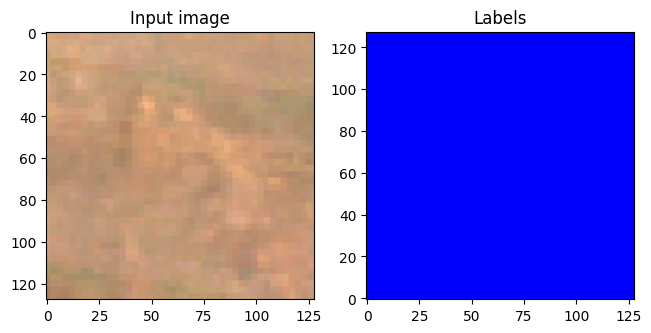

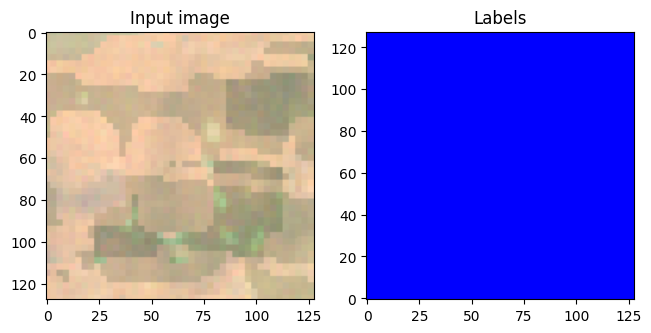

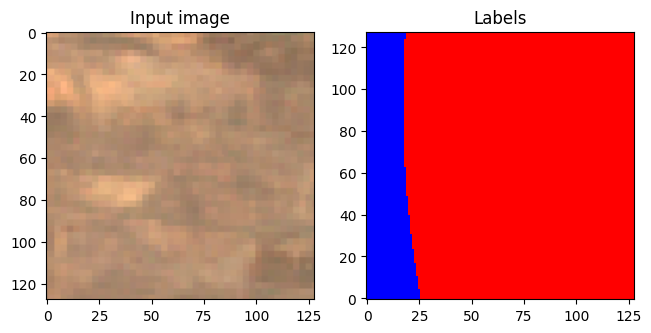

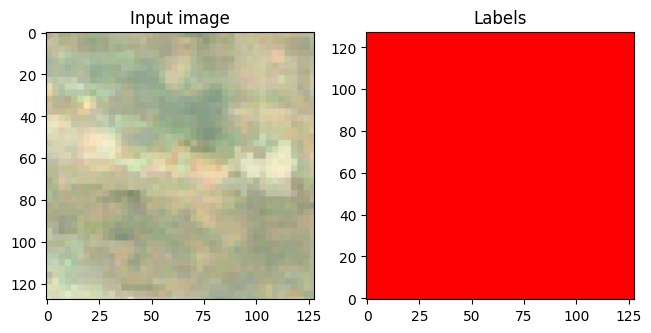

In [15]:
from create_dataset import get_training_example
from visualize import show_patches

SEED = 0

# Print input and labels for sampling of 2 points per class
# (two points )
for point in data.sample_points(seed=SEED,points_per_class=2):
  (inputs, labels) = get_training_example(point, patch_size = 128)
  show_patches(inputs, labels)

In [17]:
print(f'Image has dtype {inputs.dtype}')
print(f'Labels has dtype {labels.dtype}')

Image has dtype float64
Labels has dtype float64


# Create pipeline and do data export

Next we use an Apache-Beam pipeline to create and upload the training examples through
can create the NPZ files locally or through the distributed Dataflow runner.

## Define necessary functions for export

In [18]:
PATCH_SIZE = 128
MAX_REQUESTS = 20
POINTS_PER_CLASS = 3 # small for testing purposes

## Run the pipeline locally

In [70]:
data_path = "data/"

In [ ]:
#!pip install apache-beam[interactive]

In [15]:
import apache_beam as beam
from apache_beam.options.pipeline_options import PipelineOptions
from benin.data import sample_points
from create_dataset import write_npz

beam_options = PipelineOptions([], direct_num_workers=5)
SEED = 0

with beam.Pipeline(options=beam_options) as pipeline:
   (
      pipeline
      | "🌱 Make seeds" >> beam.Create([0])
      | "🛰 Sample points" >> beam.FlatMap(sample_points)
      | "🃏 Reshuffle" >> beam.Reshuffle()
      | "📖 Get examples" >> beam.Map(get_training_example)
      | "🗂️ Batch examples" >> beam.BatchElements()
      | "📝 Write NPZ files" >> beam.Map(write_npz, data_path)
  )

View created files

In [16]:
!ls -lh data

total 636K
-rw-r--r-- 1 root root 635K Jul  2 02:17 part-00000-of-00001.tfrecord.gz


## Use the Distributed runner

To have a remote distributed runner complete the pipeline task, we created a script, `create_dataset.py` that will `run()` our pipeline based on arguments we can adjust. To do that, it needs acceess to the data package used, so we have to build it to give to Dataflow:

In [67]:
# build benin data package to send to distributed runner
!python -m build src/benin-data

* Creating virtualenv isolated environment...
* Installing packages in isolated environment... (setuptools >= 40.8.0, wheel)
* Getting build dependencies for sdist...
running egg_info
creating benin_data.egg-info
writing benin_data.egg-info/PKG-INFO
writing dependency_links to benin_data.egg-info/dependency_links.txt
writing requirements to benin_data.egg-info/requires.txt
writing top-level names to benin_data.egg-info/top_level.txt
writing manifest file 'benin_data.egg-info/SOURCES.txt'
reading manifest file 'benin_data.egg-info/SOURCES.txt'
writing manifest file 'benin_data.egg-info/SOURCES.txt'
* Building sdist...
running sdist
running egg_info
writing benin_data.egg-info/PKG-INFO
writing dependency_links to benin_data.egg-info/dependency_links.txt
writing requirements to benin_data.egg-info/requires.txt
writing top-level names to benin_data.egg-info/top_level.txt
reading manifest file 'benin_data.egg-info/SOURCES.txt'
writing manifest file 'benin_data.egg-info/SOURCES.txt'

running

See the benin-data package

In [68]:
!ls -lh src/benin-data/dist

total 12K
-rw-r--r-- 1 root root 4.4K Jul  3 01:05 benin_data-1.1.0-py3-none-any.whl
-rw-r--r-- 1 root root 4.0K Jul  3 01:04 benin-data-1.1.0.tar.gz


Define the GC data path for the exported files:

In [72]:
data_path=f"gs://{bucket}/test_export"
print(data_path)

gs://benin-bucket1/test_export


Run the distributed runner (Dataflow):

In [91]:
!python create_dataset.py \
  --data-path="gs://example-bucket-ls-3-24/dd_test/data" \
  --ppc="{POINTS_PER_CLASS}" \
  --runner="DataflowRunner" \
  --num-workers="5"\
  --project="{project}" \
  --region="{location}" \
  --temp_location="gs://example-bucket-ls-3-24/dd_test/temp" \
  --extra_package="./src/benin-data/dist/benin-data-1.1.0.tar.gz"

INFO:apache_beam.typehints.native_type_compatibility:Converting string literal type hint to Any: "tuple"
INFO:apache_beam.typehints.native_type_compatibility:Converting string literal type hint to Any: "list[tuple[np.ndarray, np.ndarray]]"
INFO:apache_beam.typehints.native_type_compatibility:Converting string literal type hint to Any: "str"
INFO:apache_beam.typehints.native_type_compatibility:Converting string literal type hint to Any: "str"
INFO:apache_beam.runners.portability.stager:Downloading source distribution of the SDK from PyPi
INFO:apache_beam.runners.portability.stager:Executing command: ['/usr/bin/python3', '-m', 'pip', 'download', '--dest', '/tmp/tmpp685kvxq', 'apache-beam==2.48.0', '--no-deps', '--no-binary', ':all:']
INFO:apache_beam.runners.portability.stager:Staging SDK sources from PyPI: dataflow_python_sdk.tar
INFO:apache_beam.runners.portability.stager:Downloading binary distribution of the SDK from PyPi
INFO:apache_beam.runners.portability.stager:Executing command:

In [ ]:
!gsutil ls -lh gs://{bucket}/{folder}/data

# WORK IN PROGRESS Read data

####Bug #4
 Back when the data export seemed to work (up to 4/27) we still ran into errors reading in the data. We are currently getting the error:

`InvalidArgumentError: {{function_node wrappedIteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Type mismatch between parsed tensor (double) and dtype (float) [[{{node ParseTensor}}]] [Op:IteratorGetNext]`

It seems that there is some data type mismatch when creating the dataset. Immediately prior to dataset creation the inputs have dtype float64 and the labels have dtype uint8. It seems that in the tutorial before dataset creation the inputs and labels have the same data types, but upon reading the dataset it appears that both the inputs and labels are float32.

**dd_NEW**: Fixed? Untested.

In [49]:
# on 4/20, the data was written to the bucket benin_export and folder experiment_3
# using the above code (which no longer works)
bucket = 'example'
folder = 'experiment_3'
data_path=f"gs://{bucket}/{folder}"
data_path = f"gs://{bucket}/land-cover/data"
print(data_path)

gs://example/land-cover/data


**dd_NEW** Question: why is the imputs shape 13? Is this due to the serializtaion?

In [52]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
data_path = f"gs://example-bucket-ls-3-24/land-cover/data"

dataset = read_dataset(data_path)

for x, y in dataset.take(1):
  print("inputs:", x.dtype.name, x.shape)
  print("labels:", y.dtype.name, y.shape)

inputs: float32 (128, 128, 13)
labels: float32 (128, 128, 1)


# dd Unfinished work: Ignore

Currently testing: serialization and data patch validity

## Data patch testing

In [22]:
from benin.data import get_labels_image
from benin.data import sample_points

for point in sample_points(0, 2):
  print(point)

[2.474858607749282, 12.03293323078099]
[1.899936825912788, 7.325761141994698]
[2.241296633878206, 11.197500016549837]
[2.5826564418436244, 6.948468722664499]


In [12]:
%cd /content/satellite_cnns

/content/satellite_cnns


In [57]:
from create_dataset import get_training_example
point = [2.474858607749282, 12.03293323078099]
(inputs, labels) = get_training_example(point, patch_size=128)

In [64]:
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np

def show_plot(inputs_patch, labels_patch):

  inputs_visual = inputs_patch[:,:, :3]
  inputs_visual = inputs_visual/np.amax(inputs_visual)
  fig, axs = plt.subplots(1, 2, layout='constrained')

  cmap = colors.ListedColormap(['blue', 'red'])
  bounds=[0,1,2]
  norm = colors.BoundaryNorm(bounds, cmap.N)

  #plt.colorbar(img, cmap=cmap, norm=norm, boundaries=bounds, ticks=[0, 5, 10])
  axs[0].imshow(inputs_visual)
  axs[1].imshow(labels_patch, origin='lower', interpolation='nearest', cmap=cmap, norm=norm)
  axs[0].set_title("Input image")
  axs[1].set_title("Labels")
  plt.show()

In [41]:
for i in range(4):
  print(f"{inputs[i][:3]}\n")

[[1.65450000e+03 1.31650000e+03 9.65000000e+02 2.25511998e-01]
 [1.66450000e+03 1.28650000e+03 9.65000000e+02 2.10763395e-01]
 [1.66450000e+03 1.28650000e+03 9.65000000e+02 2.10763395e-01]]

[[1.64150000e+03 1.33050000e+03 1.00800000e+03 2.18798339e-01]
 [1.66100000e+03 1.30050000e+03 9.69500000e+02 2.16878831e-01]
 [1.66100000e+03 1.30050000e+03 9.69500000e+02 2.16878831e-01]]

[[1.64150000e+03 1.33050000e+03 1.00800000e+03 2.18798339e-01]
 [1.66100000e+03 1.30050000e+03 9.69500000e+02 2.16878831e-01]
 [1.66100000e+03 1.30050000e+03 9.69500000e+02 2.16878831e-01]]

[[1.64150000e+03 1.33050000e+03 1.00800000e+03 2.18798339e-01]
 [1.66100000e+03 1.30050000e+03 9.69500000e+02 2.16878831e-01]
 [1.66100000e+03 1.30050000e+03 9.69500000e+02 2.16878831e-01]]



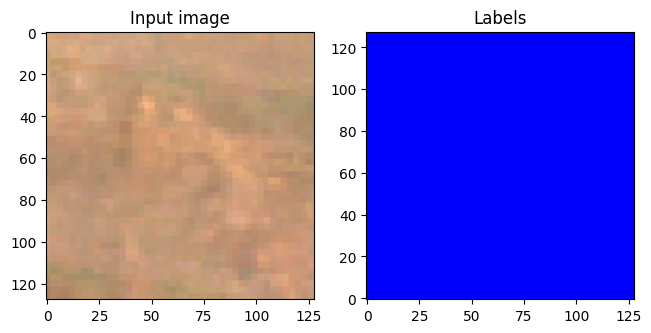

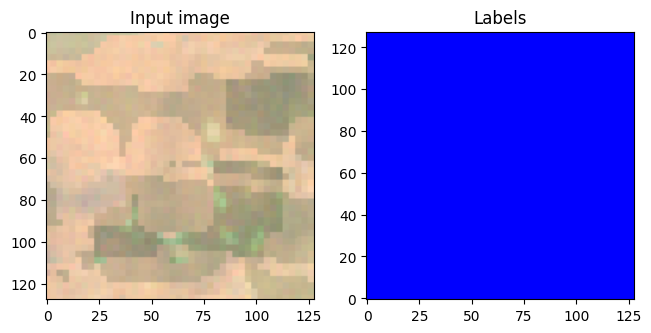

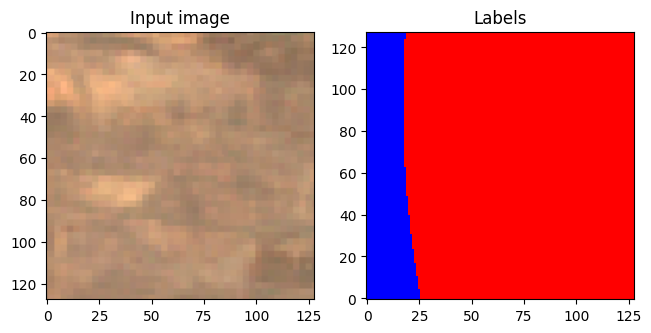

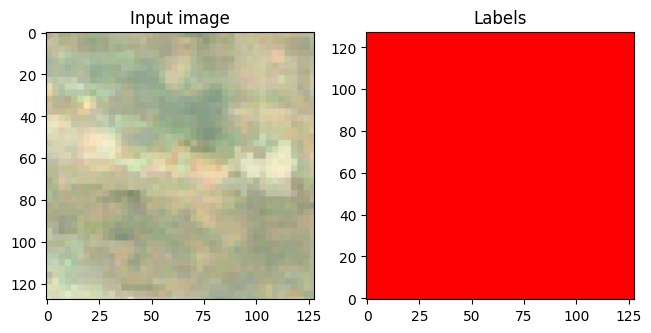

In [65]:
for point in sample_points(0,2):
  (inputs, labels) = get_training_example(point, patch_size=128)
  show_plot(inputs)

In [59]:
for point in sample_points(0,1):
  print(point)

[2.474858607749282, 12.03293323078099]
[2.241296633878206, 11.197500016549837]


## Serialize testing

Following code block from [tf_model.py](https://github.com/GoogleCloudPlatform/python-docs-samples/blob/main/people-and-planet-ai/land-cover-classification/trainer/tf_model.py#L36) from original land-cover sample

In [51]:
# coppied from

NUM_INPUTS = 13
NUM_CLASSES = 1


def read_dataset(data_path: str) -> tf.data.Dataset:
    """Reads compressed TFRecord files from a directory into a tf.data.Dataset.

    Args:
        data_path: Local or Cloud Storage directory path where the TFRecord files are.

    Returns: A tf.data.Dataset with the contents of the TFRecord files.
    """
    file_pattern = tf.io.gfile.join(data_path, "*.tfrecord.gz")
    file_names = tf.data.Dataset.list_files(file_pattern).cache()
    dataset = tf.data.TFRecordDataset(file_names, compression_type="GZIP")
    return dataset.map(read_example, num_parallel_calls=tf.data.AUTOTUNE)

def read_example(serialized: bytes) -> tuple[tf.Tensor, tf.Tensor]:
    """Parses and reads a training example from TFRecords.

    Args:
        serialized: Serialized example bytes from TFRecord files.

    Returns: An (inputs, labels) pair of tensors.
    """
    features_dict = {
        "inputs": tf.io.FixedLenFeature([], tf.string),
        "labels": tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(serialized, features_dict)
    inputs = tf.io.parse_tensor(example["inputs"], tf.float32)
    labels = tf.io.parse_tensor(example["labels"], tf.uint8)

    # TensorFlow cannot infer the shape's rank, so we set the shapes explicitly.
    inputs.set_shape([None, None, NUM_INPUTS])
    labels.set_shape([None, None, 1])

    # Classifications are measured against one-hot encoded vectors.
    one_hot_labels = tf.one_hot(labels[:, :, 0], NUM_CLASSES)
    return (inputs, one_hot_labels)

Serialization seems to be working locally... unsure of why pipeline wouldn't have access to tf

In [59]:
from create_dataset import serialize_tensorflow, get_training_example


point = [1.9046529811544155, 6.937464360434035]
(inputs, labels) = get_training_example(point)

serialized = serialize_tensorflow(inputs, labels)
print(f"serialized: {len(serialized)} bytes")

serialized: 655456 bytes


In [36]:
#from trainer.tf_model import read_dataset
import numpy as np
import matplotlib.pyplot as plt
data_path = f"gs://example-bucket-ls-3-24/land-cover/data"
dataset = read_dataset(data_path)

for x, y in dataset.take(1):
  print("inputs:", x.dtype.name, x.shape)
  print("labels:", y.dtype.name, y.shape)

inputs: float32 (128, 128, 13)
labels: float32 (128, 128, 1)


## New pipeline testing

In [74]:
from apache_beam.io.filesystems import FileSystems
from apache_beam.options.pipeline_options import PipelineOptions
import numpy as np
import uuid

def write_npz(batch: list[tuple[np.ndarray, np.ndarray]], data_path: str) -> str:
    """Writes an (inputs, labels) batch into a compressed NumPy file.

    Args:
        batch: Batch of (inputs, labels) pairs of NumPy arrays.
        data_path: Directory path to save files to.

    Returns: The filename of the data file.
    """
    filename = FileSystems.join(data_path, f"{uuid.uuid4()}.npz")
    with FileSystems.create(filename) as f:
        inputs = [x for (x, _) in batch]
        labels = [y for (_, y) in batch]
        np.savez_compressed(f, inputs=inputs, labels=labels)
    return filename

In [83]:
bucket = 'example-bucket-ls-3-24'
folder = 'dd_test'
data_path=f"gs://{bucket}/{folder}/data"

PATCH_SIZE = 128
MAX_REQUESTS = 20
POINTS_PER_CLASS = 3 # small for testing purposes

In [84]:
data_path

'gs://example-bucket-ls-3-24/dd_test/data'

In [ ]:
!pip install apache-beam[interactive]

In [88]:
import apache_beam as beam
from apache_beam.options.pipeline_options import PipelineOptions
from benin.data import sample_points

beam_options = PipelineOptions([])


with beam.Pipeline(options=beam_options) as pipeline:
   (
      pipeline
      | "🌱 Make seeds" >> beam.Create([0])
      | "🛰 Sample points" >> beam.FlatMap(sample_points)
      | "🃏 Reshuffle" >> beam.Reshuffle()
      | "📖 Get examples" >> beam.Map(get_training_example)
      | "🗂️ Batch examples" >> beam.BatchElements()
      | "📝 Write NPZ files" >> beam.Map(write_npz, data_path)
  )

In [89]:
!gsutil ls -lh gs://{bucket}/{folder}/data

 24.74 KiB  2023-07-03T02:47:51Z  gs://example-bucket-ls-3-24/dd_test/data/18c4fdf7-d37f-4e58-906c-7c2036c042ed.npz
 24.74 KiB  2023-07-03T02:43:08Z  gs://example-bucket-ls-3-24/dd_test/data/518dcc77-99b5-4f82-a697-3fc991f4a112.npz
  27.2 KiB  2023-07-03T02:47:20Z  gs://example-bucket-ls-3-24/dd_test/data/a0d6e5ef-0b81-45da-b185-83cbe38e564f.npz
 52.79 KiB  2023-07-03T02:44:04Z  gs://example-bucket-ls-3-24/dd_test/data/aa37e233-2639-40fd-bf65-7cdd45a183ef.npz
  27.2 KiB  2023-07-03T02:42:39Z  gs://example-bucket-ls-3-24/dd_test/data/af755a1e-69e6-494a-b0ac-c9f1a16545c1.npz
 52.79 KiB  2023-07-03T02:48:53Z  gs://example-bucket-ls-3-24/dd_test/data/edac60dd-fbab-45ac-84eb-d768a6ebfe83.npz
TOTAL: 6 objects, 214464 bytes (209.44 KiB)
